In [1]:
import gc
import glob
import os
import json
import matplotlib.pyplot as plt
import seaborn as sns
import pprint
import warnings

import operator
from functools import reduce

import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from joblib import Parallel, delayed
from tqdm import tqdm, tqdm_notebook

%matplotlib inline

np.random.seed(seed=1337)
warnings.filterwarnings('ignore')

split_char = '/'

In [2]:
os.listdir('../input')

['petfinder-external-data',
 'densenet-keras',
 'petfinder-adoption-prediction',
 'densenet121weights']

In [3]:
train = pd.read_csv('../input/petfinder-adoption-prediction/train/train.csv')
test = pd.read_csv('../input/petfinder-adoption-prediction/test/test.csv')
sample_submission = pd.read_csv('../input/petfinder-adoption-prediction/test/sample_submission.csv')

In [4]:
y_train = train['AdoptionSpeed'].values
group = train['RescuerID'].values

## Image features

In [5]:
import cv2
import os
from keras.applications.densenet import preprocess_input, DenseNet121

Using TensorFlow backend.


In [6]:
def resize_to_square(im):
    old_size = im.shape[:2]
    ratio = float(img_size)/max(old_size)
    new_size = tuple([int(x*ratio) for x in old_size])
    im = cv2.resize(im, (new_size[1], new_size[0]))
    delta_w = img_size - new_size[1]
    delta_h = img_size - new_size[0]
    top, bottom = delta_h//2, delta_h-(delta_h//2)
    left, right = delta_w//2, delta_w-(delta_w//2)
    color = [0, 0, 0]
    new_im = cv2.copyMakeBorder(im, top, bottom, left, right, cv2.BORDER_CONSTANT,value=color)
    return new_im

def load_image(path, pet_id):
    image = cv2.imread(f'{path}{pet_id}-1.jpg')
    new_image = resize_to_square(image)
    new_image = preprocess_input(new_image)
    return new_image

In [7]:
img_size = 256
batch_size = 256

In [8]:
from keras.models import Model
from keras.layers import GlobalAveragePooling2D, Input, Lambda, AveragePooling1D
import keras.backend as K
inp = Input((256,256,3))
backbone = DenseNet121(input_tensor = inp, 
                       weights="../input/densenet-keras/DenseNet-BC-121-32-no-top.h5",
                       include_top = False)
x = backbone.output
x = GlobalAveragePooling2D()(x)
x = Lambda(lambda x: K.expand_dims(x,axis = -1))(x)
x = AveragePooling1D(4)(x)
out = Lambda(lambda x: x[:,:,0])(x)

m = Model(inp,out)

Instructions for updating:
Colocations handled automatically by placer.


In [9]:
pet_ids = train['PetID'].values
n_batches = len(pet_ids) // batch_size + 1

features = {}
for b in tqdm(range(n_batches)):
    start = b*batch_size
    end = (b+1)*batch_size
    batch_pets = pet_ids[start:end]
    batch_images = np.zeros((len(batch_pets),img_size,img_size,3))
    for i,pet_id in enumerate(batch_pets):
        try:
            batch_images[i] = load_image("../input/petfinder-adoption-prediction/train_images/", pet_id)
        except:
            pass
    batch_preds = m.predict(batch_images)
    for i,pet_id in enumerate(batch_pets):
        features[pet_id] = batch_preds[i]

100%|██████████| 59/59 [02:14<00:00,  2.03s/it]


In [10]:
train_feats = pd.DataFrame.from_dict(features, orient='index')
train_feats.columns = [f'pic_{i}' for i in range(train_feats.shape[1])]

In [11]:
pet_ids = test['PetID'].values
n_batches = len(pet_ids) // batch_size + 1

features = {}
for b in tqdm(range(n_batches)):
    start = b*batch_size
    end = (b+1)*batch_size
    batch_pets = pet_ids[start:end]
    batch_images = np.zeros((len(batch_pets),img_size,img_size,3))
    for i,pet_id in enumerate(batch_pets):
        try:
            batch_images[i] = load_image("../input/petfinder-adoption-prediction/test_images/", pet_id)
        except:
            pass
    batch_preds = m.predict(batch_images)
    for i,pet_id in enumerate(batch_pets):
        features[pet_id] = batch_preds[i]

100%|██████████| 16/16 [00:33<00:00,  1.86s/it]


In [12]:
test_feats = pd.DataFrame.from_dict(features, orient='index')
test_feats.columns = [f'pic_{i}' for i in range(test_feats.shape[1])]

In [13]:
train_feats = train_feats.reset_index()
train_feats.rename({'index': 'PetID'}, axis='columns', inplace=True)

test_feats = test_feats.reset_index()
test_feats.rename({'index': 'PetID'}, axis='columns', inplace=True)

In [14]:
all_ids = pd.concat([train, test], axis=0, ignore_index=True, sort=False)[['PetID']]
all_ids.shape

(18941, 1)

In [15]:
n_components = 24
svd_ = TruncatedSVD(n_components=n_components, random_state=1337)

features_df = pd.concat([train_feats, test_feats], axis=0)
features = features_df[[f'pic_{i}' for i in range(256)]].values

svd_col = svd_.fit_transform(features)
svd_col = pd.DataFrame(svd_col)
svd_col = svd_col.add_prefix('IMG_SVD_')

img_features = pd.concat([all_ids, svd_col], axis=1)

In [16]:
img_features_ensemble = img_features.copy()

## About metadata and sentiment

In [17]:
labels_breed = pd.read_csv('../input/petfinder-adoption-prediction/breed_labels.csv')
labels_state = pd.read_csv('../input/petfinder-adoption-prediction/color_labels.csv')
labels_color = pd.read_csv('../input/petfinder-adoption-prediction/state_labels.csv')

In [18]:
train_image_files = sorted(glob.glob('../input/petfinder-adoption-prediction/train_images/*.jpg'))
train_metadata_files = sorted(glob.glob('../input/petfinder-adoption-prediction/train_metadata/*.json'))
train_sentiment_files = sorted(glob.glob('../input/petfinder-adoption-prediction/train_sentiment/*.json'))

print(f'num of train images files: {len(train_image_files)}')
print(f'num of train metadata files: {len(train_metadata_files)}')
print(f'num of train sentiment files: {len(train_sentiment_files)}')


test_image_files = sorted(glob.glob('../input/petfinder-adoption-prediction/test_images/*.jpg'))
test_metadata_files = sorted(glob.glob('../input/petfinder-adoption-prediction/test_metadata/*.json'))
test_sentiment_files = sorted(glob.glob('../input/petfinder-adoption-prediction/test_sentiment/*.json'))

print(f'num of test images files: {len(test_image_files)}')
print(f'num of test metadata files: {len(test_metadata_files)}')
print(f'num of test sentiment files: {len(test_sentiment_files)}')

num of train images files: 58311
num of train metadata files: 58311
num of train sentiment files: 14442
num of test images files: 15040
num of test metadata files: 15040
num of test sentiment files: 3815


### Train

In [19]:
# Images:
train_df_ids = train[['PetID']]
print(train_df_ids.shape)

# Metadata:
train_df_ids = train[['PetID']]
train_df_metadata = pd.DataFrame(train_metadata_files)
train_df_metadata.columns = ['metadata_filename']
train_metadata_pets = train_df_metadata['metadata_filename'].apply(lambda x: x.split(split_char)[-1].split('-')[0])
train_df_metadata = train_df_metadata.assign(PetID=train_metadata_pets)
print(len(train_metadata_pets.unique()))

pets_with_metadatas = len(np.intersect1d(train_metadata_pets.unique(), train_df_ids['PetID'].unique()))
print(f'fraction of pets with metadata: {pets_with_metadatas / train_df_ids.shape[0]:.3f}')

# Sentiment:
train_df_ids = train[['PetID']]
train_df_sentiment = pd.DataFrame(train_sentiment_files)
train_df_sentiment.columns = ['sentiment_filename']
train_sentiment_pets = train_df_sentiment['sentiment_filename'].apply(lambda x: x.split(split_char)[-1].split('.')[0])
train_df_sentiment = train_df_sentiment.assign(PetID=train_sentiment_pets)
print(len(train_sentiment_pets.unique()))

pets_with_sentiments = len(np.intersect1d(train_sentiment_pets.unique(), train_df_ids['PetID'].unique()))
print(f'fraction of pets with sentiment: {pets_with_sentiments / train_df_ids.shape[0]:.3f}')

(14993, 1)
14652
fraction of pets with metadata: 0.977
14442
fraction of pets with sentiment: 0.963


### Test

In [20]:
# Images:
test_df_ids = test[['PetID']]
print(test_df_ids.shape)

# Metadata:
test_df_metadata = pd.DataFrame(test_metadata_files)
test_df_metadata.columns = ['metadata_filename']
test_metadata_pets = test_df_metadata['metadata_filename'].apply(lambda x: x.split(split_char)[-1].split('-')[0])
test_df_metadata = test_df_metadata.assign(PetID=test_metadata_pets)
print(len(test_metadata_pets.unique()))

pets_with_metadatas = len(np.intersect1d(test_metadata_pets.unique(), test_df_ids['PetID'].unique()))
print(f'fraction of pets with metadata: {pets_with_metadatas / test_df_ids.shape[0]:.3f}')

# Sentiment:
test_df_sentiment = pd.DataFrame(test_sentiment_files)
test_df_sentiment.columns = ['sentiment_filename']
test_sentiment_pets = test_df_sentiment['sentiment_filename'].apply(lambda x: x.split(split_char)[-1].split('.')[0])
test_df_sentiment = test_df_sentiment.assign(PetID=test_sentiment_pets)
print(len(test_sentiment_pets.unique()))

pets_with_sentiments = len(np.intersect1d(test_sentiment_pets.unique(), test_df_ids['PetID'].unique()))
print(f'fraction of pets with sentiment: {pets_with_sentiments / test_df_ids.shape[0]:.3f}')

(3948, 1)
3821
fraction of pets with metadata: 0.968
3815
fraction of pets with sentiment: 0.966


## Extract features from json

In [21]:
class PetFinderParser(object):
    
    def __init__(self, debug=False):
        
        self.debug = debug
        self.sentence_sep = ' '
        
        self.extract_sentiment_text = False
    
    def open_json_file(self, filename):
        with open(filename, 'r', encoding='utf-8') as f:
            json_file = json.load(f)
        return json_file
        
    def parse_sentiment_file(self, file):
        """
        Parse sentiment file. Output DF with sentiment features.
        """
        
        file_sentiment = file['documentSentiment']
        file_entities = [x['name'] for x in file['entities']]
        file_entities = self.sentence_sep.join(file_entities)
        
        file_sentences_sentiment = [x['sentiment'] for x in file['sentences']]
        
        file_sentences_sentiment = pd.DataFrame.from_dict(
            file_sentences_sentiment, orient='columns')
        file_sentences_sentiment_df = pd.DataFrame(
            {
                'magnitude_sum': file_sentences_sentiment['magnitude'].sum(axis=0),
                'score_sum': file_sentences_sentiment['score'].sum(axis=0),
                'magnitude_mean': file_sentences_sentiment['magnitude'].mean(axis=0),
                'score_mean': file_sentences_sentiment['score'].mean(axis=0),
                'magnitude_var': file_sentences_sentiment['magnitude'].var(axis=0),
                'score_var': file_sentences_sentiment['score'].var(axis=0),
            }, index=[0]
        )
        
        df_sentiment = pd.DataFrame.from_dict(file_sentiment, orient='index').T
        df_sentiment = pd.concat([df_sentiment, file_sentences_sentiment_df], axis=1)
            
        df_sentiment['entities'] = file_entities
        df_sentiment = df_sentiment.add_prefix('sentiment_')
        
        return df_sentiment
    
    def extract_area_from_vertices(self, vertices):
        coordinates = {'x': set(), 'y': set()}
        for vertex in vertices:
            coordinates['x'].add(vertex.get('x', 0))
            coordinates['y'].add(vertex.get('y', 0))
        edge_len = [abs(np.diff(list(value))[0]) for value in coordinates.values()]
        return reduce(operator.mul, edge_len)
    
    def parse_metadata_file(self, file):
        """
        Parse metadata file. Output DF with metadata features.
        """
        
        file_keys = list(file.keys())
        
        if 'labelAnnotations' in file_keys:
            file_annots = file['labelAnnotations']
            file_top_score = np.asarray([x['score'] for x in file_annots]).mean()
            file_top_desc = [x['description'] for x in file_annots]
        else:
            file_top_score = np.nan
            file_top_desc = ['']
        
        file_colors = file['imagePropertiesAnnotation']['dominantColors']['colors']
        file_crops = file['cropHintsAnnotation']['cropHints']

        file_color_score = np.asarray([x['score'] for x in file_colors]).mean()
        file_color_pixelfrac = np.asarray([x['pixelFraction'] for x in file_colors]).mean()

        file_crop_conf = np.asarray([x['confidence'] for x in file_crops])
        
        if 'boundingPoly' in file_crops[0].keys() and 'vertices' in file_crops[0]['boundingPoly'].keys():
            file_crop_area = np.asarray([
                self.extract_area_from_vertices(x['boundingPoly']['vertices']) for x in file_crops
            ])
        else:
            file_crop_area = np.nan
        
        if 'importanceFraction' in file_crops[0].keys():
            file_crop_importance = np.asarray([x['importanceFraction'] for x in file_crops])
        else:
            file_crop_importance = np.nan

        df_metadata = {
            'annots_score': file_top_score,
            'color_score': file_color_score,
            'color_pixelfrac': file_color_pixelfrac,
            'crop_area': file_crop_area.mean(),
            'crop_area_conf': (file_crop_area * file_crop_conf).mean(),
            'crop_area_importance': (file_crop_area * file_crop_importance).mean(),
            'annots_top_desc': self.sentence_sep.join(file_top_desc)
        }
        
        df_metadata = pd.DataFrame.from_dict(df_metadata, orient='index').T
        df_metadata = df_metadata.add_prefix('metadata_')
        
        return df_metadata
    

def extract_additional_features(pet_id, mode='train'):
    
    sentiment_filename = f'../input/petfinder-adoption-prediction/{mode}_sentiment/{pet_id}.json'
    try:
        sentiment_file = pet_parser.open_json_file(sentiment_filename)
        df_sentiment = pet_parser.parse_sentiment_file(sentiment_file)
        df_sentiment['PetID'] = pet_id
    except FileNotFoundError:
        df_sentiment = []

    dfs_metadata = []
    metadata_filenames = sorted(glob.glob(f'../input/petfinder-adoption-prediction/{mode}_metadata/{pet_id}*.json'))
    if len(metadata_filenames) > 0:
        for f in metadata_filenames:
            metadata_file = pet_parser.open_json_file(f)
            df_metadata = pet_parser.parse_metadata_file(metadata_file)
            df_metadata['PetID'] = pet_id
            dfs_metadata.append(df_metadata)
        dfs_metadata = pd.concat(dfs_metadata, ignore_index=True, sort=False)
    dfs = [df_sentiment, dfs_metadata]
    
    return dfs


pet_parser = PetFinderParser()

In [22]:
debug = False
train_pet_ids = train.PetID.unique()
test_pet_ids = test.PetID.unique()

if debug:
    train_pet_ids = train_pet_ids[:1000]
    test_pet_ids = test_pet_ids[:500]


dfs_train = Parallel(n_jobs=-1, verbose=1)(
    delayed(extract_additional_features)(i, mode='train') for i in train_pet_ids)

train_dfs_sentiment = [x[0] for x in dfs_train if isinstance(x[0], pd.DataFrame)]
train_dfs_metadata = [x[1] for x in dfs_train if isinstance(x[1], pd.DataFrame)]

train_dfs_sentiment = pd.concat(train_dfs_sentiment, ignore_index=True, sort=False)
train_dfs_metadata = pd.concat(train_dfs_metadata, ignore_index=True, sort=False)

print(train_dfs_sentiment.shape, train_dfs_metadata.shape)


dfs_test = Parallel(n_jobs=-1, verbose=1)(
    delayed(extract_additional_features)(i, mode='test') for i in test_pet_ids)

test_dfs_sentiment = [x[0] for x in dfs_test if isinstance(x[0], pd.DataFrame)]
test_dfs_metadata = [x[1] for x in dfs_test if isinstance(x[1], pd.DataFrame)]

test_dfs_sentiment = pd.concat(test_dfs_sentiment, ignore_index=True, sort=False)
test_dfs_metadata = pd.concat(test_dfs_metadata, ignore_index=True, sort=False)

print(test_dfs_sentiment.shape, test_dfs_metadata.shape)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   20.2s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:   39.2s
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1246 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 1796 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 2446 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 3196 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 4046 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 4996 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 6046 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done 7196 tasks      | elapsed:  8.5min
[Parallel(n_jobs=-1)]: Done 8446 tasks      | elapsed:  9.9min
[Parallel(n_jobs=-1)]: Done 9796 tasks      | elapsed: 11.4min
[Parallel(n_jobs=-1)]: Done 11246 tasks      |

(14442, 10) (58311, 8)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 324 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 1524 tasks      | elapsed:   37.1s
[Parallel(n_jobs=-1)]: Done 3524 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 3948 out of 3948 | elapsed:  1.6min finished


(3815, 10) (15040, 8)


### group extracted features by PetID:

In [23]:
aggregates = ['sum', 'mean', 'var']
sent_agg = ['sum']


# Train
train_metadata_desc = train_dfs_metadata.groupby(['PetID'])['metadata_annots_top_desc'].unique()
train_metadata_desc = train_metadata_desc.reset_index()
train_metadata_desc[
    'metadata_annots_top_desc'] = train_metadata_desc[
    'metadata_annots_top_desc'].apply(lambda x: ' '.join(x))

prefix = 'metadata'
train_metadata_gr = train_dfs_metadata.drop(['metadata_annots_top_desc'], axis=1)
for i in train_metadata_gr.columns:
    if 'PetID' not in i:
        train_metadata_gr[i] = train_metadata_gr[i].astype(float)
train_metadata_gr = train_metadata_gr.groupby(['PetID']).agg(aggregates)
train_metadata_gr.columns = pd.Index([f'{c[0]}_{c[1].upper()}' for c in train_metadata_gr.columns.tolist()])
train_metadata_gr = train_metadata_gr.reset_index()


train_sentiment_desc = train_dfs_sentiment.groupby(['PetID'])['sentiment_entities'].unique()
train_sentiment_desc = train_sentiment_desc.reset_index()
train_sentiment_desc[
    'sentiment_entities'] = train_sentiment_desc[
    'sentiment_entities'].apply(lambda x: ' '.join(x))

prefix = 'sentiment'
train_sentiment_gr = train_dfs_sentiment.drop(['sentiment_entities'], axis=1)
for i in train_sentiment_gr.columns:
    if 'PetID' not in i:
        train_sentiment_gr[i] = train_sentiment_gr[i].astype(float)
train_sentiment_gr = train_sentiment_gr.groupby(['PetID']).agg(sent_agg)
train_sentiment_gr.columns = pd.Index([f'{c[0]}' for c in train_sentiment_gr.columns.tolist()])
train_sentiment_gr = train_sentiment_gr.reset_index()


# Test
test_metadata_desc = test_dfs_metadata.groupby(['PetID'])['metadata_annots_top_desc'].unique()
test_metadata_desc = test_metadata_desc.reset_index()
test_metadata_desc[
    'metadata_annots_top_desc'] = test_metadata_desc[
    'metadata_annots_top_desc'].apply(lambda x: ' '.join(x))

prefix = 'metadata'
test_metadata_gr = test_dfs_metadata.drop(['metadata_annots_top_desc'], axis=1)
for i in test_metadata_gr.columns:
    if 'PetID' not in i:
        test_metadata_gr[i] = test_metadata_gr[i].astype(float)
test_metadata_gr = test_metadata_gr.groupby(['PetID']).agg(aggregates)
test_metadata_gr.columns = pd.Index([f'{c[0]}_{c[1].upper()}' for c in test_metadata_gr.columns.tolist()])
test_metadata_gr = test_metadata_gr.reset_index()


test_sentiment_desc = test_dfs_sentiment.groupby(['PetID'])['sentiment_entities'].unique()
test_sentiment_desc = test_sentiment_desc.reset_index()
test_sentiment_desc[
    'sentiment_entities'] = test_sentiment_desc[
    'sentiment_entities'].apply(lambda x: ' '.join(x))

prefix = 'sentiment'
test_sentiment_gr = test_dfs_sentiment.drop(['sentiment_entities'], axis=1)
for i in test_sentiment_gr.columns:
    if 'PetID' not in i:
        test_sentiment_gr[i] = test_sentiment_gr[i].astype(float)
test_sentiment_gr = test_sentiment_gr.groupby(['PetID']).agg(sent_agg)
test_sentiment_gr.columns = pd.Index([f'{c[0]}' for c in test_sentiment_gr.columns.tolist()])
test_sentiment_gr = test_sentiment_gr.reset_index()

### merge processed DFs with base train/test DF:

In [24]:
# Train merges:
train_proc = train.copy()
train_proc = train_proc.merge(
    train_sentiment_gr, how='left', on='PetID')
train_proc = train_proc.merge(
    train_metadata_gr, how='left', on='PetID')
train_proc = train_proc.merge(
    train_metadata_desc, how='left', on='PetID')
train_proc = train_proc.merge(
    train_sentiment_desc, how='left', on='PetID')

# Test merges:
test_proc = test.copy()
test_proc = test_proc.merge(
    test_sentiment_gr, how='left', on='PetID')
test_proc = test_proc.merge(
    test_metadata_gr, how='left', on='PetID')
test_proc = test_proc.merge(
    test_metadata_desc, how='left', on='PetID')
test_proc = test_proc.merge(
    test_sentiment_desc, how='left', on='PetID')

print(train_proc.shape, test_proc.shape)
assert train_proc.shape[0] == train.shape[0]
assert test_proc.shape[0] == test.shape[0]

(14993, 52) (3948, 51)


In [25]:
train_breed_main = train_proc[['Breed1']].merge(
    labels_breed, how='left',
    left_on='Breed1', right_on='BreedID',
    suffixes=('', '_main_breed'))

train_breed_main = train_breed_main.iloc[:, 2:]
train_breed_main = train_breed_main.add_prefix('main_breed_')

train_breed_second = train_proc[['Breed2']].merge(
    labels_breed, how='left',
    left_on='Breed2', right_on='BreedID',
    suffixes=('', '_second_breed'))

train_breed_second = train_breed_second.iloc[:, 2:]
train_breed_second = train_breed_second.add_prefix('second_breed_')


train_proc = pd.concat(
    [train_proc, train_breed_main, train_breed_second], axis=1)


test_breed_main = test_proc[['Breed1']].merge(
    labels_breed, how='left',
    left_on='Breed1', right_on='BreedID',
    suffixes=('', '_main_breed'))

test_breed_main = test_breed_main.iloc[:, 2:]
test_breed_main = test_breed_main.add_prefix('main_breed_')

test_breed_second = test_proc[['Breed2']].merge(
    labels_breed, how='left',
    left_on='Breed2', right_on='BreedID',
    suffixes=('', '_second_breed'))

test_breed_second = test_breed_second.iloc[:, 2:]
test_breed_second = test_breed_second.add_prefix('second_breed_')


test_proc = pd.concat(
    [test_proc, test_breed_main, test_breed_second], axis=1)

print(train_proc.shape, test_proc.shape)

(14993, 56) (3948, 55)


In [26]:
X = pd.concat([train_proc, test_proc], ignore_index=True, sort=False)

In [27]:
X_temp = X.copy()

text_columns = ['Description', 'metadata_annots_top_desc', 'sentiment_entities']
categorical_columns = ['main_breed_BreedName', 'second_breed_BreedName']

to_drop_columns = ['PetID', 'Name', 'RescuerID']

In [28]:
rescuer_count = X.groupby(['RescuerID'])['PetID'].count().reset_index()
rescuer_count.columns = ['RescuerID', 'RescuerID_COUNT']

X_temp = X_temp.merge(rescuer_count, how='left', on='RescuerID')

In [29]:
for i in categorical_columns:
    X_temp.loc[:, i] = pd.factorize(X_temp.loc[:, i])[0]

In [30]:
X_text = X_temp[text_columns]

for i in X_text.columns:
    X_text.loc[:, i] = X_text.loc[:, i].fillna('none')

In [31]:
X_temp['Length_Description'] = X_text['Description'].map(len)
X_temp['Length_metadata_annots_top_desc'] = X_text['metadata_annots_top_desc'].map(len)
X_temp['Lengths_sentiment_entities'] = X_text['sentiment_entities'].map(len)

### TFIDF

In [32]:
n_components = 16
text_features = []

# Generate text features:
for i in X_text.columns:
    
    # Initialize decomposition methods:
    print(f'generating features from: {i}')
    tfv = TfidfVectorizer(min_df=2,  max_features=None,
                          strip_accents='unicode', analyzer='word', token_pattern=r'(?u)\b\w+\b',
                          ngram_range=(1, 3), use_idf=1, smooth_idf=1, sublinear_tf=1)
    svd_ = TruncatedSVD(
        n_components=n_components, random_state=1337)
    
    tfidf_col = tfv.fit_transform(X_text.loc[:, i].values)
    
    svd_col = svd_.fit_transform(tfidf_col)
    svd_col = pd.DataFrame(svd_col)
    svd_col = svd_col.add_prefix('TFIDF_{}_'.format(i))
    
    text_features.append(svd_col)
    
text_features = pd.concat(text_features, axis=1)
text_features_ensemble = text_features.copy()

X_temp = pd.concat([X_temp, text_features], axis=1)

for i in X_text.columns:
    X_temp = X_temp.drop(i, axis=1)

generating features from: Description
generating features from: metadata_annots_top_desc
generating features from: sentiment_entities


### Merge image features

In [33]:
X_temp = X_temp.merge(img_features, how='left', on='PetID')

### Add image_size features

In [34]:
from PIL import Image
train_df_ids = train[['PetID']]
test_df_ids = test[['PetID']]

train_df_imgs = pd.DataFrame(train_image_files)
train_df_imgs.columns = ['image_filename']
train_imgs_pets = train_df_imgs['image_filename'].apply(lambda x: x.split(split_char)[-1].split('-')[0])

test_df_imgs = pd.DataFrame(test_image_files)
test_df_imgs.columns = ['image_filename']
test_imgs_pets = test_df_imgs['image_filename'].apply(lambda x: x.split(split_char)[-1].split('-')[0])

train_df_imgs = train_df_imgs.assign(PetID=train_imgs_pets)
test_df_imgs = test_df_imgs.assign(PetID=test_imgs_pets)

def getSize(filename):
    st = os.stat(filename)
    return st.st_size

def getDimensions(filename):
    img_size = Image.open(filename).size
    return img_size 

train_df_imgs['image_size'] = train_df_imgs['image_filename'].apply(getSize)
train_df_imgs['temp_size'] = train_df_imgs['image_filename'].apply(getDimensions)
train_df_imgs['width'] = train_df_imgs['temp_size'].apply(lambda x : x[0])
train_df_imgs['height'] = train_df_imgs['temp_size'].apply(lambda x : x[1])
train_df_imgs['image_ratio'] = train_df_imgs['width'] / train_df_imgs['height']
train_df_imgs['image_area'] = train_df_imgs['width'] * train_df_imgs['height']
train_df_imgs = train_df_imgs.drop(['temp_size'], axis=1)

test_df_imgs['image_size'] = test_df_imgs['image_filename'].apply(getSize)
test_df_imgs['temp_size'] = test_df_imgs['image_filename'].apply(getDimensions)
test_df_imgs['width'] = test_df_imgs['temp_size'].apply(lambda x : x[0])
test_df_imgs['height'] = test_df_imgs['temp_size'].apply(lambda x : x[1])
test_df_imgs['image_ratio'] = test_df_imgs['width'] / test_df_imgs['height']
test_df_imgs['image_area'] = test_df_imgs['width'] * test_df_imgs['height']
test_df_imgs = test_df_imgs.drop(['temp_size'], axis=1)

aggs = {
    'image_size': ['sum', 'mean', 'var'],
    'width': ['sum', 'mean', 'var'],
    'height': ['sum', 'mean', 'var'],
    'image_ratio': ['sum', 'mean', 'var'],
    'image_area': ['sum', 'mean', 'var']
}

agg_train_imgs = train_df_imgs.groupby('PetID').agg(aggs)
new_columns = [
    k + '_' + agg for k in aggs.keys() for agg in aggs[k]
]
agg_train_imgs.columns = new_columns
agg_train_imgs = agg_train_imgs.reset_index()

agg_test_imgs = test_df_imgs.groupby('PetID').agg(aggs)
new_columns = [
    k + '_' + agg for k in aggs.keys() for agg in aggs[k]
]
agg_test_imgs.columns = new_columns
agg_test_imgs = agg_test_imgs.reset_index()

agg_imgs = pd.concat([agg_train_imgs, agg_test_imgs], axis=0).reset_index(drop=True)
agg_imgs_ensemble = agg_imgs.copy()

In [35]:
X_temp = X_temp.merge(agg_imgs, how='left', on='PetID')
X_temp['crop_per_image_mean'] = X_temp['metadata_crop_area_MEAN'] / X_temp['image_size_mean']

### Drop ID, name and rescuerID

In [36]:
X_temp = X_temp.drop(to_drop_columns, axis=1)

In [37]:
X_train = X_temp.loc[np.isfinite(X_temp.AdoptionSpeed), :]
X_test = X_temp.loc[~np.isfinite(X_temp.AdoptionSpeed), :]

X_test = X_test.drop(['AdoptionSpeed'], axis=1)

assert X_train.shape[0] == train.shape[0]
assert X_test.shape[0] == test.shape[0]

train_cols = X_train.columns.tolist()
train_cols.remove('AdoptionSpeed')

test_cols = X_test.columns.tolist()

assert np.all(train_cols == test_cols)

In [38]:
X_train_non_null = X_train.fillna(-1)
X_test_non_null = X_test.fillna(-1)

In [39]:
X_train_non_null.isnull().any().any(), X_test_non_null.isnull().any().any()

(False, False)

In [40]:
X_train_non_null.shape, X_test_non_null.shape

((14993, 142), (3948, 141))

In [41]:
import scipy as sp

from collections import Counter
from functools import partial
from math import sqrt

from sklearn.metrics import cohen_kappa_score, mean_squared_error
from sklearn.metrics import confusion_matrix as sk_cmatrix


# FROM: https://www.kaggle.com/myltykritik/simple-lgbm-image-features

# The following 3 functions have been taken from Ben Hamner's github repository
# https://github.com/benhamner/Metrics
def confusion_matrix(rater_a, rater_b, min_rating=None, max_rating=None):
    """
    Returns the confusion matrix between rater's ratings
    """
    assert(len(rater_a) == len(rater_b))
    if min_rating is None:
        min_rating = min(rater_a + rater_b)
    if max_rating is None:
        max_rating = max(rater_a + rater_b)
    num_ratings = int(max_rating - min_rating + 1)
    conf_mat = [[0 for i in range(num_ratings)]
                for j in range(num_ratings)]
    for a, b in zip(rater_a, rater_b):
        conf_mat[a - min_rating][b - min_rating] += 1
    return conf_mat


def histogram(ratings, min_rating=None, max_rating=None):
    """
    Returns the counts of each type of rating that a rater made
    """
    if min_rating is None:
        min_rating = min(ratings)
    if max_rating is None:
        max_rating = max(ratings)
    num_ratings = int(max_rating - min_rating + 1)
    hist_ratings = [0 for x in range(num_ratings)]
    for r in ratings:
        hist_ratings[r - min_rating] += 1
    return hist_ratings


def quadratic_weighted_kappa(y, y_pred):
    """
    Calculates the quadratic weighted kappa
    axquadratic_weighted_kappa calculates the quadratic weighted kappa
    value, which is a measure of inter-rater agreement between two raters
    that provide discrete numeric ratings.  Potential values range from -1
    (representing complete disagreement) to 1 (representing complete
    agreement).  A kappa value of 0 is expected if all agreement is due to
    chance.
    quadratic_weighted_kappa(rater_a, rater_b), where rater_a and rater_b
    each correspond to a list of integer ratings.  These lists must have the
    same length.
    The ratings should be integers, and it is assumed that they contain
    the complete range of possible ratings.
    quadratic_weighted_kappa(X, min_rating, max_rating), where min_rating
    is the minimum possible rating, and max_rating is the maximum possible
    rating
    """
    rater_a = y
    rater_b = y_pred
    min_rating=None
    max_rating=None
    rater_a = np.array(rater_a, dtype=int)
    rater_b = np.array(rater_b, dtype=int)
    assert(len(rater_a) == len(rater_b))
    if min_rating is None:
        min_rating = min(min(rater_a), min(rater_b))
    if max_rating is None:
        max_rating = max(max(rater_a), max(rater_b))
    conf_mat = confusion_matrix(rater_a, rater_b,
                                min_rating, max_rating)
    num_ratings = len(conf_mat)
    num_scored_items = float(len(rater_a))

    hist_rater_a = histogram(rater_a, min_rating, max_rating)
    hist_rater_b = histogram(rater_b, min_rating, max_rating)

    numerator = 0.0
    denominator = 0.0

    for i in range(num_ratings):
        for j in range(num_ratings):
            expected_count = (hist_rater_a[i] * hist_rater_b[j]
                              / num_scored_items)
            d = pow(i - j, 2.0) / pow(num_ratings - 1, 2.0)
            numerator += d * conf_mat[i][j] / num_scored_items
            denominator += d * expected_count / num_scored_items

    return (1.0 - numerator / denominator)

### OptimizeRounder from [OptimizedRounder() - Improved](https://www.kaggle.com/naveenasaithambi/optimizedrounder-improved)

In [42]:
def to_bins(x, borders):
    for i in range(len(borders)):
        if x <= borders[i]:
            return i
    return len(borders)

class OptimizedRounder(object):
    def __init__(self):
        self.coef_ = 0

    def _loss(self, coef, X, y, idx):
        X_p = np.array([to_bins(pred, coef) for pred in X])
        ll = -quadratic_weighted_kappa(y, X_p)
        return ll

    def fit(self, X, y):
        coef = [1.5, 2.0, 2.5, 3.0]
        golden1 = 0.618
        golden2 = 1 - golden1
        ab_start = [(1, 2), (1.5, 2.5), (2, 3), (2.5, 3.5)]
        for it1 in range(10):
            for idx in range(4):
                # golden section search
                a, b = ab_start[idx]
                # calc losses
                coef[idx] = a
                la = self._loss(coef, X, y, idx)
                coef[idx] = b
                lb = self._loss(coef, X, y, idx)
                for it in range(20):
                    # choose value
                    if la > lb:
                        a = b - (b - a) * golden1
                        coef[idx] = a
                        la = self._loss(coef, X, y, idx)
                    else:
                        b = b - (b - a) * golden2
                        coef[idx] = b
                        lb = self._loss(coef, X, y, idx)
        self.coef_ = {'x': coef}

    def predict(self, X, coef):
        X_p = np.array([to_bins(pred, coef) for pred in X])
        return X_p

    def coefficients(self):
        return self.coef_['x']

## Train model

In [43]:
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold

xgb_params = {
    'eval_metric': 'rmse',
    'seed': 1337,
    'eta': 0.00723,
    'subsample': 0.8,
    'colsample_bytree': 0.85,
    'tree_method': 'gpu_hist',
    'device': 'gpu',
    'silent': 1,
}

In [44]:
def run_xgb(params, X_train, X_test):
    n_splits = 10
    verbose_eval = 1000
    num_rounds = 60000
    early_stop = 500

    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=1337)

    oof_train = np.zeros((X_train.shape[0]))
    oof_test = np.zeros((X_test.shape[0], n_splits))

    i = 0

    for train_idx, valid_idx in kf.split(X_train, X_train['AdoptionSpeed'].values):

        X_tr = X_train.iloc[train_idx, :]
        X_val = X_train.iloc[valid_idx, :]

        y_tr = X_tr['AdoptionSpeed'].values
        X_tr = X_tr.drop(['AdoptionSpeed'], axis=1)

        y_val = X_val['AdoptionSpeed'].values
        X_val = X_val.drop(['AdoptionSpeed'], axis=1)

        d_train = xgb.DMatrix(data=X_tr, label=y_tr, feature_names=X_tr.columns)
        d_valid = xgb.DMatrix(data=X_val, label=y_val, feature_names=X_val.columns)

        watchlist = [(d_train, 'train'), (d_valid, 'valid')]
        model = xgb.train(dtrain=d_train, num_boost_round=num_rounds, evals=watchlist,
                         early_stopping_rounds=early_stop, verbose_eval=verbose_eval, params=params)

        valid_pred = model.predict(xgb.DMatrix(X_val, feature_names=X_val.columns), ntree_limit=model.best_ntree_limit)
        test_pred = model.predict(xgb.DMatrix(X_test, feature_names=X_test.columns), ntree_limit=model.best_ntree_limit)

        oof_train[valid_idx] = valid_pred
        oof_test[:, i] = test_pred

        i += 1
    return model, oof_train, oof_test

In [45]:
model, oof_train, oof_test = run_xgb(xgb_params, X_train_non_null, X_test_non_null)

[0]	train-rmse:2.32152	valid-rmse:2.32183
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 500 rounds.
[1000]	train-rmse:0.791701	valid-rmse:1.02398
[2000]	train-rmse:0.636784	valid-rmse:1.01615
[3000]	train-rmse:0.516164	valid-rmse:1.01494
Stopping. Best iteration:
[2884]	train-rmse:0.528884	valid-rmse:1.01464

[0]	train-rmse:2.32154	valid-rmse:2.32188
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 500 rounds.
[1000]	train-rmse:0.791231	valid-rmse:1.04394
[2000]	train-rmse:0.640847	valid-rmse:1.03583
[3000]	train-rmse:0.522509	valid-rmse:1.03198
[4000]	train-rmse:0.426149	valid-rmse:1.03062
Stopping. Best iteration:
[4268]	train-rmse:0.403098	valid-rmse:1.03019

[0]	train-rmse:2.32159	valid-rmse:2.32189
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse

In [46]:
def plot_pred(pred):
    sns.distplot(pred, kde=True, hist_kws={'range': [0, 5]})

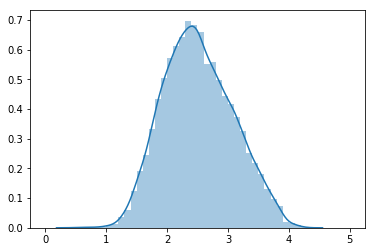

In [47]:
plot_pred(oof_train)

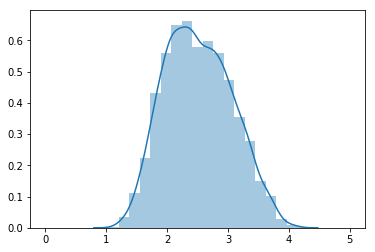

In [48]:
plot_pred(oof_test.mean(axis=1))

In [49]:
optR = OptimizedRounder()
optR.fit(oof_train, X_train['AdoptionSpeed'].values)
coefficients = optR.coefficients()
valid_pred = optR.predict(oof_train, coefficients)
qwk = quadratic_weighted_kappa(X_train['AdoptionSpeed'].values, valid_pred)
print("QWK = ", qwk)

QWK =  0.48644663726231696


In [50]:
coefficients_ = coefficients.copy()
coefficients_[0] = 1.66
coefficients_[1] = 2.13
coefficients_[3] = 2.85
train_predictions1 = optR.predict(oof_train, coefficients_).astype(np.int8)
print(f'train pred distribution: {Counter(train_predictions1)}')
test_predictions = optR.predict(oof_test.mean(axis=1), coefficients_).astype(np.int8)
print(f'test pred distribution: {Counter(test_predictions)}')

train pred distribution: Counter({4: 4206, 2: 3746, 1: 3176, 3: 2991, 0: 874})
test pred distribution: Counter({4: 1128, 2: 945, 1: 918, 3: 780, 0: 177})


In [51]:
Counter(train_predictions1)

Counter({3: 2991, 1: 3176, 2: 3746, 4: 4206, 0: 874})

In [52]:
Counter(test_predictions)

Counter({1: 918, 4: 1128, 3: 780, 2: 945, 0: 177})

In [53]:
submission1 = pd.DataFrame({'PetID': test['PetID'].values, 'AdoptionSpeed': test_predictions})

# XGBoost

In [54]:
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold

xgb_params = {
    'eval_metric': 'rmse',
    'seed': 1337,
    'eta': 0.00723,
    'subsample': 0.8,
    'colsample_bytree': 0.85,
    'tree_method': 'gpu_hist',
    'device': 'gpu',
    'silent': 1,
}

lgb_params = {'application': 'regression',
          'boosting': 'gbdt',
          'metric': 'rmse',
          'max_depth': -1,
          'learning_rate': 0.007,
          'bagging_fraction': 0.9,
          'subsample': 0.8,
          'colsample_bytree': 0.85,
          'verbosity': -1,
          'data_random_seed': 17,
          'DUSE_GPU' : 1}

In [55]:
train_columns = [c for c in X_train_non_null.columns if c not in ['AdoptionSpeed','RescuerID']]

In [56]:
from sklearn.model_selection import GroupKFold

def run_lgb_xgb(xgb_params,lgb_params, X_train, X_test):
    n_splits = 10
    verbose_eval = 1000
    num_rounds = 60000
    early_stop = 500

    #kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=1337)
    kf = GroupKFold(n_splits=n_splits)

    oof_train = np.zeros((X_train.shape[0]))
    oof_test = np.zeros((X_test.shape[0], n_splits))

    oof_train1 = np.zeros((X_train.shape[0]))
    oof_test1 = np.zeros((X_test.shape[0], n_splits)) 
    
    i = 0

    for train_idx, valid_idx in kf.split(X_train, X_train['AdoptionSpeed'].values, group):

        X_tr = X_train.iloc[train_idx, :]
        X_val = X_train.iloc[valid_idx, :]

        y_tr = X_tr['AdoptionSpeed'].values
        X_tr = X_tr[train_columns]
        
        y_val = X_val['AdoptionSpeed'].values
        X_val = X_val[train_columns]

        d_train = xgb.DMatrix(data=X_tr, label=y_tr, feature_names=X_tr.columns)
        d_valid = xgb.DMatrix(data=X_val, label=y_val, feature_names=X_val.columns)
        
        trn_data = lgb.Dataset(X_tr, label=y_tr)#, categorical_feature=categorical_feats)
        val_data = lgb.Dataset(X_val, label=y_val)#, categorical_feature=categorical_feats)

        watchlist = [(d_train, 'train'), (d_valid, 'valid')]
        print("xgboost...")
        model = xgb.train(dtrain=d_train, num_boost_round=50000, evals=watchlist,
                         early_stopping_rounds=500, verbose_eval=1000, params=xgb_params)
        print("lightgbm...")
        clf = lgb.train(lgb_params, trn_data, 50000, valid_sets = [trn_data, val_data], verbose_eval=1000, early_stopping_rounds = 500)
        
        valid_pred = model.predict(xgb.DMatrix(X_val, feature_names=train_columns), ntree_limit=model.best_ntree_limit)
        test_pred = model.predict(xgb.DMatrix(X_test[train_columns], feature_names=train_columns), ntree_limit=model.best_ntree_limit)
    
        oof_train[valid_idx] = valid_pred
        oof_train1[valid_idx] = clf.predict(X_val, num_iteration=clf.best_iteration)
        oof_test[:, i] = test_pred
        oof_test1[:, i] = clf.predict(X_test[train_columns], num_iteration=clf.best_iteration)

        i += 1
    return model, oof_train, oof_test, clf, oof_train1, oof_test1

In [57]:
model, oof_train, oof_test, clf, oof_train1, oof_test1 = run_lgb_xgb(xgb_params,lgb_params, X_train_non_null, X_test_non_null)

xgboost...
[0]	train-rmse:2.32482	valid-rmse:2.29271
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 500 rounds.
[1000]	train-rmse:0.796851	valid-rmse:1.01223
Stopping. Best iteration:
[1279]	train-rmse:0.749536	valid-rmse:1.00995

lightgbm...
Training until validation scores don't improve for 500 rounds.
[1000]	training's rmse: 0.866957	valid_1's rmse: 1.01411
Early stopping, best iteration is:
[1454]	training's rmse: 0.806503	valid_1's rmse: 1.01309
xgboost...
[0]	train-rmse:2.3191	valid-rmse:2.34369
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 500 rounds.
[1000]	train-rmse:0.791774	valid-rmse:1.02556
[2000]	train-rmse:0.639761	valid-rmse:1.023
[3000]	train-rmse:0.520964	valid-rmse:1.02225
Stopping. Best iteration:
[2966]	train-rmse:0.524536	valid-rmse:1.02218

lightgbm...
Training until validation scores don't 

In [58]:
from sklearn.metrics import mean_squared_error
target = X_train_non_null['AdoptionSpeed']
print("xgboost:",mean_squared_error(oof_train,target)**0.5,"lightgbm:",mean_squared_error(oof_train1,target)**0.5)

xgboost: 1.0495051730577059 lightgbm: 1.053031744455272


In [59]:
optR = OptimizedRounder()
oof_train2 = 0.7*oof_train + 0.3*oof_train1
optR.fit(oof_train2, X_train['AdoptionSpeed'].values)
coefficients = optR.coefficients()
valid_pred = optR.predict(oof_train2, coefficients)
qwk = quadratic_weighted_kappa(X_train['AdoptionSpeed'].values, valid_pred)
print("QWK = ", qwk)

QWK =  0.4381681661107606


In [60]:
coefficients_ = coefficients.copy()
coefficients_[0] = 1.66
coefficients_[1] = 2.13
coefficients_[3] = 2.85
train_predictions2 = optR.predict(oof_train2, coefficients_).astype(np.int8)
print(f'train pred distribution: {Counter(train_predictions2)}')
oof_test2 = 0.7*oof_test + 0.3*oof_test1
test_predictions = optR.predict(oof_test2.mean(axis=1), coefficients_).astype(np.int8)
print(f'test pred distribution: {Counter(test_predictions)}')

train pred distribution: Counter({4: 3936, 2: 3859, 3: 3393, 1: 3291, 0: 514})
test pred distribution: Counter({4: 1105, 2: 948, 1: 923, 3: 858, 0: 114})


In [61]:
submission2 = pd.DataFrame({'PetID': test['PetID'].values, 'AdoptionSpeed': test_predictions})

# Ensemble 
https://www.kaggle.com/sakami/external-data-weighted-average-prediction/log

In [62]:
from tensorflow import set_random_seed
set_random_seed(2019)

In [63]:
state = pd.read_csv("../input/petfinder-external-data/petfinder_external_state.csv")
state = state[['StateID','Population']]
state.columns = ['State','Population']

In [64]:
x_count = X_temp[['State','Type']]
x_count = x_count.groupby(['State','Type'])['State'].agg({'count'}).reset_index()
x_count = x_count.merge(state,on='State',how='left')
x_count['demand_rate'] = 100*x_count['count']/x_count['Population']
x_count = x_count[['State','Type','demand_rate']]

In [65]:
X_temp = pd.merge(X_temp,x_count,how='left',on=['State','Type'])
X_train = X_temp.loc[np.isfinite(X_temp.AdoptionSpeed), :]
X_test = X_temp.loc[~np.isfinite(X_temp.AdoptionSpeed), :]

X_test = X_test.drop(['AdoptionSpeed'], axis=1)

assert X_train.shape[0] == train.shape[0]
assert X_test.shape[0] == test.shape[0]

train_cols = X_train.columns.tolist()
train_cols.remove('AdoptionSpeed')

test_cols = X_test.columns.tolist()

assert np.all(train_cols == test_cols)

In [66]:
X_train_non_null = X_train.fillna(-1)
X_test_non_null = X_test.fillna(-1)

In [67]:
def frequency_encoding(train, test, categorical_features):
    x_train = train.copy()
    x_test = test.copy()
    x = pd.concat([x_train, x_test], axis=0, ignore_index=True)
    for cat in categorical_features:
        new_column = cat + '_count'
        cat_counts = x[cat].value_counts().to_dict()
        x_train[new_column] = train[cat].map(cat_counts)
        x_test[new_column] = test[cat].map(cat_counts).fillna(0)

    return x_train, x_test

In [68]:
cat_features = [
    'Type',
    'Breed1',
    'Breed2',
    'Color1',
    'Color2',
    'Color3',
    'State'
]

X_train_non_null, X_test_non_null = frequency_encoding(X_train_non_null, X_test_non_null, cat_features)

In [69]:
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor
from sklearn.model_selection import StratifiedKFold

xgb_params = {
    'eval_metric': 'rmse',
    'seed': 1337,
    'eta': 0.00723,
    'subsample': 0.8,
    'colsample_bytree': 0.85,
    'tree_method': 'gpu_hist',
    'device': 'gpu',
    'silent': 1,
}

lgb_params = {'application': 'regression',
              'boosting': 'gbdt',
              'metric': 'rmse',
              'num_leaves': 70,
#               'max_depth': 9,
              'learning_rate': 0.00723,
              'bagging_fraction': 0.8,
              'feature_fraction': 0.85,
    #           'min_split_gain': 0.02,
    #           'min_child_samples': 150,
    #           'min_child_weight': 0.02,
              'lambda_l2': 0.0475,
              'verbosity': -1,
              'data_random_seed': 1337}

cat_params = {
          'depth': 8,
          'eta': 0.02,
          'task_type' :"GPU",
          'random_strength': 1.5,
          'loss_function': 'RMSE',
#           'one_hot_max_size': 2,
          'reg_lambda': 6,
          'od_type': 'Iter',
#           'fold_len_multiplier': 2,
          'border_count': 128,
#           # 'od_type': 'IncToDec',
#           # 'od_pval': 10e-5, 
          'bootstrap_type' : "Bayesian",
#           'bagging_temperature': 1,
          'random_seed': 1337,
          'early_stopping_rounds': 500, 
          'num_boost_round': 5000}

In [70]:
def run_lgb(params, X_train, X_test):
    n_splits = 10
    verbose_eval = 1000
    num_rounds = 60000
    early_stop = 500

    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=1337)

    oof_train = np.zeros((X_train.shape[0]))
    oof_test = np.zeros((X_test.shape[0]))

    for train_idx, valid_idx in kf.split(X_train, X_train['AdoptionSpeed'].values):

        X_tr = X_train.iloc[train_idx, :]
        X_val = X_train.iloc[valid_idx, :]

        y_tr = X_tr['AdoptionSpeed'].values
        X_tr = X_tr.drop(['AdoptionSpeed'], axis=1)

        y_val = X_val['AdoptionSpeed'].values
        X_val = X_val.drop(['AdoptionSpeed'], axis=1)

        d_train = lgb.Dataset(X_tr, label=y_tr)
        d_valid = lgb.Dataset(X_val, label=y_val)
        watchlist = [d_train, d_valid]

        model = lgb.train(params,
                      train_set=d_train,
                      num_boost_round=num_rounds,
                      valid_sets=watchlist,
                      verbose_eval=verbose_eval,
                      early_stopping_rounds=early_stop)
    
        valid_pred = model.predict(X_val, num_iteration=model.best_iteration)
        test_pred = model.predict(X_test, num_iteration=model.best_iteration)

        oof_train[valid_idx] = valid_pred
        oof_test += test_pred / n_splits

    return model, oof_train, oof_test

def run_xgb(params, X_train, X_test):
    n_splits = 10
    verbose_eval = 1000
    num_rounds = 60000
    early_stop = 500

    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=1337)

    oof_train = np.zeros((X_train.shape[0]))
    oof_test = np.zeros((X_test.shape[0]))

    for train_idx, valid_idx in kf.split(X_train, X_train['AdoptionSpeed'].values):

        X_tr = X_train.iloc[train_idx, :]
        X_val = X_train.iloc[valid_idx, :]

        y_tr = X_tr['AdoptionSpeed'].values
        X_tr = X_tr.drop(['AdoptionSpeed'], axis=1)

        y_val = X_val['AdoptionSpeed'].values
        X_val = X_val.drop(['AdoptionSpeed'], axis=1)

        d_train = xgb.DMatrix(data=X_tr, label=y_tr, feature_names=X_tr.columns)
        d_valid = xgb.DMatrix(data=X_val, label=y_val, feature_names=X_val.columns)

        watchlist = [(d_train, 'train'), (d_valid, 'valid')]
        model = xgb.train(dtrain=d_train, num_boost_round=num_rounds, evals=watchlist,
                         early_stopping_rounds=early_stop, verbose_eval=verbose_eval, params=params)

        valid_pred = model.predict(xgb.DMatrix(X_val, feature_names=X_val.columns), ntree_limit=model.best_ntree_limit)
        test_pred = model.predict(xgb.DMatrix(X_test, feature_names=X_test.columns), ntree_limit=model.best_ntree_limit)

        oof_train[valid_idx] = valid_pred
        oof_test += test_pred / n_splits

    return model, oof_train, oof_test

def run_cat(params, X_train, X_test):
    n_splits = 5
    verbose_eval = 1000
    num_rounds = 2500
    early_stop = 500

    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=1337)

    oof_train = np.zeros((X_train.shape[0]))
    oof_test = np.zeros((X_test.shape[0]))

    for train_idx, valid_idx in kf.split(X_train, X_train['AdoptionSpeed'].values):

        X_tr = X_train.iloc[train_idx, :]
        X_val = X_train.iloc[valid_idx, :]

        y_tr = X_tr['AdoptionSpeed'].values
        X_tr = X_tr.drop(['AdoptionSpeed'], axis=1)

        y_val = X_val['AdoptionSpeed'].values
        X_val = X_val.drop(['AdoptionSpeed'], axis=1)

        watchlist = (X_tr, y_tr)
        model = CatBoostRegressor(**params)
        model.fit(X_tr, y_tr, eval_set=watchlist, verbose=verbose_eval, use_best_model=True)
    
        valid_pred = model.predict(X_val)
        test_pred = model.predict(X_test)

        oof_train[valid_idx] = valid_pred
        oof_test += test_pred / n_splits

    return model, oof_train, oof_test

In [71]:
model, oof_train_0, oof_test_0 = run_lgb(lgb_params, X_train_non_null, X_test_non_null)
model, oof_train_1, oof_test_1 = run_xgb(xgb_params, X_train_non_null, X_test_non_null)
model, oof_train_2, oof_test_2 = run_cat(cat_params, X_train_non_null, X_test_non_null)

Training until validation scores don't improve for 500 rounds.
[1000]	training's rmse: 0.678538	valid_1's rmse: 1.02084
[2000]	training's rmse: 0.484942	valid_1's rmse: 1.01424
[3000]	training's rmse: 0.353021	valid_1's rmse: 1.0136
Early stopping, best iteration is:
[2809]	training's rmse: 0.375355	valid_1's rmse: 1.01323
Training until validation scores don't improve for 500 rounds.
[1000]	training's rmse: 0.678667	valid_1's rmse: 1.04063
[2000]	training's rmse: 0.486801	valid_1's rmse: 1.03745
[3000]	training's rmse: 0.356447	valid_1's rmse: 1.03522
[4000]	training's rmse: 0.262744	valid_1's rmse: 1.03362
[5000]	training's rmse: 0.195314	valid_1's rmse: 1.03303
Early stopping, best iteration is:
[4966]	training's rmse: 0.197339	valid_1's rmse: 1.03297
Training until validation scores don't improve for 500 rounds.
[1000]	training's rmse: 0.679589	valid_1's rmse: 1.01109
[2000]	training's rmse: 0.486749	valid_1's rmse: 1.00331
[3000]	training's rmse: 0.354395	valid_1's rmse: 1.00207
[

0:	learn: 2.7330827	test: 2.7330828	best: 2.7330828 (0)	total: 48.7ms	remaining: 4m 3s
1000:	learn: 0.9201255	test: 0.9201255	best: 0.9201255 (1000)	total: 40.3s	remaining: 2m 40s
2000:	learn: 0.8320163	test: 0.8320163	best: 0.8320163 (2000)	total: 1m 21s	remaining: 2m 2s
3000:	learn: 0.7721385	test: 0.7721385	best: 0.7721385 (3000)	total: 2m 2s	remaining: 1m 21s
4000:	learn: 0.7244850	test: 0.7244850	best: 0.7244850 (4000)	total: 2m 43s	remaining: 40.8s
4999:	learn: 0.6831712	test: 0.6831712	best: 0.6831712 (4999)	total: 3m 24s	remaining: 0us
bestTest = 0.6831711771
bestIteration = 4999


0:	learn: 2.7330597	test: 2.7330597	best: 2.7330597 (0)	total: 43.9ms	remaining: 3m 39s
1000:	learn: 0.9258729	test: 0.9258729	best: 0.9258729 (1000)	total: 40.3s	remaining: 2m 41s
2000:	learn: 0.8363174	test: 0.8363174	best: 0.8363174 (2000)	total: 1m 22s	remaining: 2m 3s
3000:	learn: 0.7737079	test: 0.7737079	best: 0.7737079 (3000)	total: 2m 3s	remaining: 1m 22s
4000:	learn: 0.7300348	test: 0.7300349	best: 0.7300349 (4000)	total: 2m 43s	remaining: 40.9s
4999:	learn: 0.6896538	test: 0.6896538	best: 0.6896538 (4999)	total: 3m 24s	remaining: 0us
bestTest = 0.6896538386
bestIteration = 4999


0:	learn: 2.7330761	test: 2.7330761	best: 2.7330761 (0)	total: 46.5ms	remaining: 3m 52s
1000:	learn: 0.9217438	test: 0.9217438	best: 0.9217438 (1000)	total: 40.8s	remaining: 2m 43s
2000:	learn: 0.8225246	test: 0.8225245	best: 0.8225245 (2000)	total: 1m 23s	remaining: 2m 5s
3000:	learn: 0.7513646	test: 0.7513646	best: 0.7513646 (3000)	total: 2m 6s	remaining: 1m 24s
4000:	learn: 0.6993426	test: 0.6993426	best: 0.6993426 (4000)	total: 2m 49s	remaining: 42.2s
4999:	learn: 0.6594244	test: 0.6594244	best: 0.6594244 (4999)	total: 3m 31s	remaining: 0us
bestTest = 0.659424359
bestIteration = 4999


0:	learn: 2.7330819	test: 2.7330820	best: 2.7330820 (0)	total: 43.6ms	remaining: 3m 37s
1000:	learn: 0.9295434	test: 0.9295434	best: 0.9295434 (1000)	total: 40s	remaining: 2m 39s
2000:	learn: 0.8378253	test: 0.8378253	best: 0.8378253 (2000)	total: 1m 22s	remaining: 2m 3s
3000:	learn: 0.7681354	test: 0.7681355	best: 0.7681355 (3000)	total: 2m 3s	remaining: 1m 22s
4000:	learn: 0.7158566	test: 0.7158566	best: 0.7158566 (4000)	total: 2m 45s	remaining: 41.4s
4999:	learn: 0.6741690	test: 0.6741689	best: 0.6741689 (4999)	total: 3m 27s	remaining: 0us
bestTest = 0.6741689316
bestIteration = 4999


0:	learn: 2.7332996	test: 2.7332996	best: 2.7332996 (0)	total: 44.2ms	remaining: 3m 40s
1000:	learn: 0.9258483	test: 0.9258483	best: 0.9258483 (1000)	total: 40.2s	remaining: 2m 40s
2000:	learn: 0.8232912	test: 0.8232912	best: 0.8232912 (2000)	total: 1m 22s	remaining: 2m 3s
3000:	learn: 0.7501655	test: 0.7501655	best: 0.7501655 (3000)	total: 2m 5s	remaining: 1m 23s
4000:	learn: 0.6982737	test: 0.6982737	best: 0.6982737 (4000)	total: 2m 47s	remaining: 41.9s
4999:	learn: 0.6567524	test: 0.6567523	best: 0.6567523 (4999)	total: 3m 30s	remaining: 0us
bestTest = 0.6567523314
bestIteration = 4999


In [72]:
from sklearn.linear_model import LinearRegression

oof_train_0 = oof_train_0[:, np.newaxis]
oof_train_1 = oof_train_1[:, np.newaxis]
oof_train_2 = oof_train_2[:, np.newaxis]
oof_train = np.hstack((oof_train_0, oof_train_1, oof_train_2))
y_train = X_train_non_null['AdoptionSpeed'].values

oof_test_0 = oof_test_0[:, np.newaxis]
oof_test_1 = oof_test_1[:, np.newaxis]
oof_test_2 = oof_test_2[:, np.newaxis]
oof_test = np.hstack((oof_test_0, oof_test_1, oof_test_2))

linear_model = LinearRegression()
linear_model.fit(oof_train, y_train)
oof_train = linear_model.predict(oof_train)
oof_test = linear_model.predict(oof_test)

linear_model.coef_

array([0.41793311, 0.47533859, 0.15950911])

In [73]:
optR = OptimizedRounder()
optR.fit(oof_train, y_train)
coefficients = optR.coefficients()
valid_pred = optR.predict(oof_train, coefficients)
qwk = quadratic_weighted_kappa(y_train, valid_pred)
test_predictions = optR.predict(oof_test, coefficients).astype(np.int8)
print("QWK = ", qwk)

QWK =  0.490463620386108


In [74]:
train_predictions3 = valid_pred

In [75]:
submission3 = pd.DataFrame({'PetID': test['PetID'].values, 'AdoptionSpeed': test_predictions})

In [76]:
submission1["AdoptionSpeed"] = submission1.AdoptionSpeed*0.4 + submission2.AdoptionSpeed*0.2 + submission3.AdoptionSpeed*0.4
submission1["AdoptionSpeed"] = submission1["AdoptionSpeed"].round().astype(int)
submission1.to_csv('submission.csv', index=False)